# Regression and Other Stories: Residuals
Plotting the data and fitted model. See Chapter 11 in Regression and Other Stories.

In [2]:
import arviz as az
from bambi import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Fake Data

In [12]:
N = 100
x = stats.uniform(0, 1).rvs(N)
z = np.random.choice((0, 1),N, replace=True)
a = 1
b = 2
theta = 5
sigma = 2
y = a + b*x + theta*z + stats.norm(0, sigma).rvs(N)
fake = pd.DataFrame(dict(x=x, y=y, z=z))

### Model

In [37]:
model = Model(fake)
results = model.fit('y ~ x + z', samples=1000, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sd, z, x, Intercept]
INFO:pymc3:NUTS: [y_sd, z, x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
/opt/conda/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [43]:
coefs = results.posterior.median().to_dict()["data_vars"]
coefs

{'Intercept': {'dims': (), 'attrs': {}, 'data': -0.3544611591985709},
 'x': {'dims': (), 'attrs': {}, 'data': 3.7649086862174137},
 'z': {'dims': (), 'attrs': {}, 'data': 5.28612767522082},
 'y_sd': {'dims': (), 'attrs': {}, 'data': 2.0019370729701684}}

### Plot Predictor vs Outcome

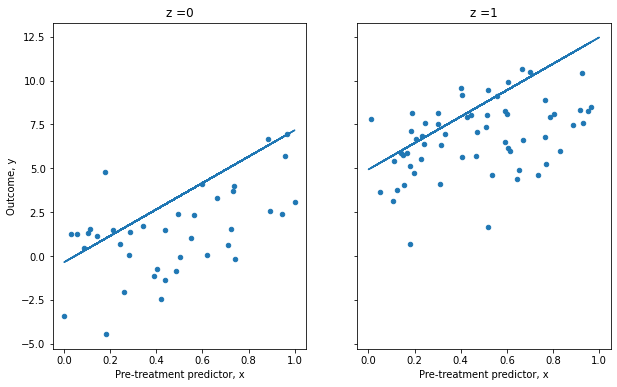

In [44]:
fig, axes = plt.subplots(1,2, figsize=(10, 6), sharey=True)
x_domain = np.linspace(0,1, 100)

for i in range(2):
    fake[fake["z"]==i].plot(x="x", y="y", kind="scatter", ax=axes[i])
    axes[i].set_xlabel("Pre-treatment predictor, x")
    axes[i].set_ylabel("Outcome, y")
    axes[i].set_title(f"z ={i}")
    
    # TODO: Verify this is correct
    axes[i].plot(x, coefs["Intercept"]["data"]+ coefs["x"]["data"]*x + coefs["x"]["data"]*x + coefs["z"]["data"]*i  )

## More complicated model with multiple pre-treatment predictors.
### Fake Data

In [82]:
N = 100
K = 10
x = stats.uniform(0, 1).rvs((N, K))
z = np.random.choice((0, 1),N, replace=True)
a = 1
b = np.arange(1,K+1)
theta = 5
sigma = 2
y = a + np.dot(x,b) + theta*z + stats.norm(0, sigma).rvs(N)

# Explode out X
cols =  {"y":y, "z":z, **{f"x_{i}":x[:,i] for i in range(x.shape[1])}}
fake = pd.DataFrame(cols)
fake.head()

,y,z,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,23.126752,0,0.938803,0.772113,0.237460,0.800887,0.738983,0.176829,0.660719,0.048031,0.388608,0.148981
1,38.145709,1,0.714910,0.003961,0.119581,0.169798,0.557277,0.572905,0.931774,0.918628,0.791660,0.149864
2,31.535240,1,0.429462,0.238995,0.398665,0.358720,0.529842,0.208472,0.987319,0.056076,0.150846,0.727583
3,26.260523,0,0.693660,0.405202,0.096370,0.954292,0.602330,0.355876,0.036215,0.975262,0.424816,0.455872
4,38.499261,1,0.523540,0.091338,0.507924,0.891211,0.950609,0.607868,0.414483,0.874839,0.685147,0.178979


## TODO: Figure out if there's an easy way for patsy to explode out all levels like ROS does for "Big X"

In [ ]:
model = Model(fake)
results = model.fit('y ~ x + z', samples=1000, chains=4)

In [ ]:
# TODO: Add predict method that gets posterior predictive to bambi